# Notes:
- This code is an interpretation that mixes both main.ipynb and models_arrangement.py in order to plot step by step what is hapenning in each proposed step.

# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from math import cos, sin, dist
from random import randint, shuffle

from sklearn.cluster import DBSCAN

# Functions

## devices_proximity_checker

In [2]:
# Compares the coordinates of 2 devices and calculates their distances in 
# order to check if they are in the range of their communication.
def devices_proximity_checker(device_x_coords, 
                              device_y_coords, 
                              devices_communication_radius):
    if (device_y_coords[0] - devices_communication_radius) <= device_x_coords[0] <= (device_y_coords[0] + devices_communication_radius) and \
       (device_y_coords[1] - devices_communication_radius) <= device_x_coords[1] <= (device_y_coords[1] + devices_communication_radius):
        devices_distance = dist(device_x_coords, device_y_coords)
        if devices_distance <= devices_communication_radius:
            return True
        else:
            return False
    else:
        return False

## devices_generator

In [3]:
def devices_generator(number_of_devices, bs_radius):
    devices_information_dict = dict()
    devices_information_list = list()
    for device in range(number_of_devices):
        # Polar coordinates.
        device_angle = randint(0, 360) # In polar coordinates, this means the θ(theta) value.
        distance_from_device_to_BS = randint(1, bs_radius) # In polar coordinates, this means the radius.
        
        # Polar to cartesian coordinates.
        x_coord = distance_from_device_to_BS * cos(device_angle) # radius*cos(angle_theta).
        y_coord = distance_from_device_to_BS * sin(device_angle) # radius*sin(angle_theta).

        # Adding more device informations.
        device_battery = randint(1, 100) # Battery between 1 and 100 percent.
        stats_product = distance_from_device_to_BS * device_battery
        
        # Generate the dictionary.
        devices_information_dict[device] = {'device_angle': device_angle,
                                            'distance_from_device_to_BS': distance_from_device_to_BS,
                                            'x_y_coord': (x_coord, y_coord),
                                            'device_battery': device_battery,
                                            'stats_product': stats_product}

        # The below list will be passed to numba, as the dictionary is 
        # more complex to work with in numba.
        device_information = [device, 
                              device_angle, 
                              distance_from_device_to_BS, 
                              device_battery]
        devices_information_list.append(device_information)
    return devices_information_dict, devices_information_list

## clusters_plotter

In [4]:
def clusters_plotter(title, figure_save_name):
    list_of_devices_x_coord = list()
    list_of_devices_y_coord = list()

    list_of_clusterheads_x_coords = list()
    list_of_clusterheads_y_coords = list()

    list_of_unclustered_devices_x_coords = list()
    list_of_unclustered_devices_y_coords = list()

    for clusterhead in dict_of_clusters.keys():
        # Clusterheads.
        clusterhead_x_coord = devices_information_dict[clusterhead]['x_y_coord'][0]
        list_of_clusterheads_x_coords.append(clusterhead_x_coord)
        clusterhead_y_coord = devices_information_dict[clusterhead]['x_y_coord'][1]
        list_of_clusterheads_y_coords.append(clusterhead_y_coord)

        # Clustered devices.
        for device in dict_of_clusters[clusterhead]:
            device_x_coord = devices_information_dict[device]['x_y_coord'][0]
            list_of_devices_x_coord.append(device_x_coord)
            device_y_coord = devices_information_dict[device]['x_y_coord'][1]
            list_of_devices_y_coord.append(device_y_coord)

    # Unclustered devices.
    for device in list_of_unclustered_devices:
        device_x_coord = devices_information_dict[device]['x_y_coord'][0]
        list_of_unclustered_devices_x_coords.append(device_x_coord)
        device_y_coord = devices_information_dict[device]['x_y_coord'][1]
        list_of_unclustered_devices_y_coords.append(device_y_coord)

    plt.Figure()
    plt.rcParams["figure.figsize"] = [8, 8]
    plt.plot(list_of_devices_x_coord, list_of_devices_y_coord, 'bo', label='Clustered Devices')
    plt.plot(list_of_clusterheads_x_coords, list_of_clusterheads_y_coords, 'go', label='Clusterheads')
    plt.plot(list_of_unclustered_devices_x_coords, list_of_unclustered_devices_y_coords, 'ro', label='Unclustered devices')
    plt.plot(0, 0, 'k*', markersize=20, label='BS')
    plt.xlim([0-BS_RADIUS, 0+BS_RADIUS])
    plt.ylim([0-BS_RADIUS, 0+BS_RADIUS])
    plt.legend(loc="upper right")
    # plt.title(title)
    plt.xlabel('Distance in meters')
    plt.ylabel('Distance in meters')

    plt.savefig(f'Figures/{figure_save_name}.eps', format='eps')
    plt.show()
    
    return

## clusters_reporter

In [5]:
def clusters_reporter():
    number_of_cluster_size_dict = dict()
    for clusterhead in dict_of_clusters.keys():
        cluster_size = len(dict_of_clusters[clusterhead]) + 1
        if cluster_size in list(number_of_cluster_size_dict.keys()):
            number_of_cluster_size_dict[cluster_size] = number_of_cluster_size_dict[cluster_size] + 1
        else:
            number_of_cluster_size_dict[cluster_size] = 1

    print(f'There are {len(dict_of_clusters)} clusters in total.')
    print('')
    print(f'From these clusters, there are:')
    ordered_number_of_clusters = sorted(list(number_of_cluster_size_dict.keys()))
    number_of_sucessfully_clustered_devices = 0
    number_of_unsucessfully_clustered_devices = 0
    for key in ordered_number_of_clusters:
        print(f'{number_of_cluster_size_dict[key]} clusters of size {key}')
        number_of_sucessfully_clustered_devices = number_of_sucessfully_clustered_devices + key*number_of_cluster_size_dict[key]

    print('')    
    print(f'Totalizing in {number_of_sucessfully_clustered_devices} clustered devices (out of {number_of_mobile_devices_k}), which means {number_of_sucessfully_clustered_devices/number_of_mobile_devices_k*100}% of the devices were sucessfully clustered.')
    print(f'There is also {len(list_of_unclustered_devices)} devices that did not group with any other device.')


## is_value_present_checker

In [6]:
# This function was created in order to check that no device is belonging in more than one cluster at the same time.
def is_value_present_checker(created_dictionary, value):
    list_of_keys_that_has_the_element = list()
    for key, list_values in created_dictionary.items():
        if value in list_values:
            list_of_keys_that_has_the_element.append(key)
    if len(list_of_keys_that_has_the_element) > 0:
        return list_of_keys_that_has_the_element
    else:
        return -1

# Variables declaration

In [7]:
# These are the same variables that are inside the "main.ipynb
BS_RADIUS = 300
device_radius = 15
max_devices_per_cluster = 10
min_devices_per_cluster = 4
number_of_mobile_devices_k = 1000


# Generating devices

In [8]:
devices_with_information_dict, \
devices_with_information_list = devices_generator(number_of_devices=number_of_mobile_devices_k, 
                                                  bs_radius=BS_RADIUS)

## Plotting generated devices

In [9]:
x_coords_list = list()
y_coords_list = list()

for key in devices_with_information_dict.keys():
    x_coord = devices_with_information_dict[key]['x_y_coord'][0]
    y_coord = devices_with_information_dict[key]['x_y_coord'][1]
    
    x_coords_list.append(x_coord)
    y_coords_list.append(y_coord)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


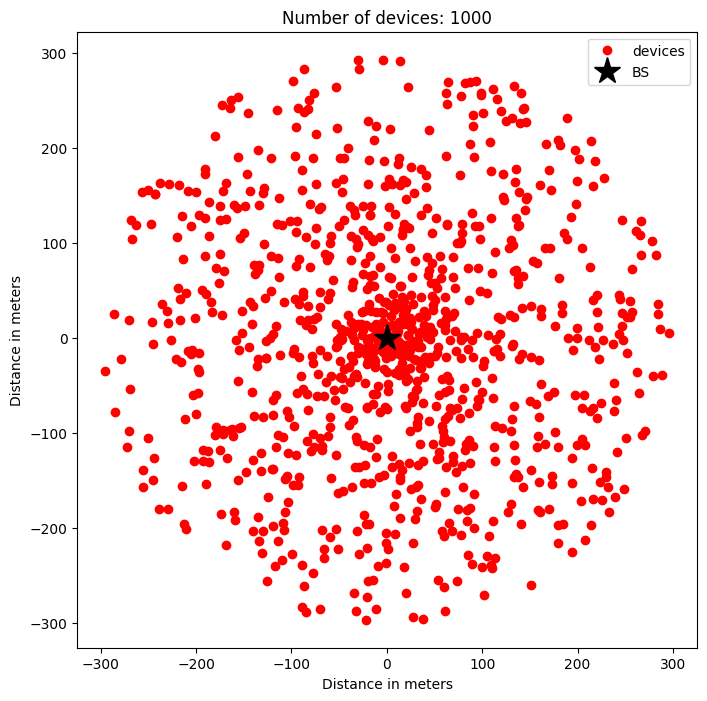

In [10]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.plot(x_coords_list, y_coords_list, 'ro', label='devices')
plt.plot(0, 0, 'k*', markersize=20, label='BS')
plt.legend(loc="upper right")
plt.title(f'Number of devices: {number_of_mobile_devices_k}')
plt.xlabel('Distance in meters')
plt.ylabel('Distance in meters')
plt.savefig(f'Figures/clusterization_part_0--{number_of_mobile_devices_k}_devices.eps', format='eps')
plt.show()

# Devices clusterization

## Notes
Clusters header: | device clusterhead | device member 1 | device member 2 ... |

In [11]:
devices_information_dict = devices_with_information_dict

## Clusterization - part 1
Creation of the first clusters (composed of 2 devices).
- Selects 1 device as the reference one (chosen randomly).
- Then check all other devices that are near this reference device.
- Orders (by the distance) all near devices to the reference one.
- Finally, select the closest device to the reference one in order to create a cluster with it.
- Repeat this process until there is no device available.

In [12]:
temporary_list_of_available_devices = list(devices_information_dict.keys())

list_of_unclustered_devices = list()
dict_of_clusters = dict()
while len(temporary_list_of_available_devices) != 0:
    # Selects one device as the reference device.
    reference_device = temporary_list_of_available_devices[0]
    reference_device_coords = devices_information_dict[reference_device]['x_y_coord']
    # The below line removes the selected user so that it is not used twice.
    temporary_list_of_available_devices.remove(reference_device) 

    # Now find all devices that are near this reference device.
    reference_device_neighbors_list = list()
    for analysed_device in temporary_list_of_available_devices:
        analysed_device_coords = devices_information_dict[analysed_device]['x_y_coord']
        devices_are_near = devices_proximity_checker(device_x_coords=reference_device_coords, 
                                                     device_y_coords=analysed_device_coords, 
                                                     devices_communication_radius=device_radius)
        if devices_are_near is True:
            neighbor_distance = dist(reference_device_coords, analysed_device_coords)
            reference_device_neighbors_list.append((analysed_device, neighbor_distance))
        else:
            pass

    # Grabs the device with the closest distance (in cases the device has any neighbors).
    if len(reference_device_neighbors_list) > 0:
        # The below line orders the devices based on the distance, which is the second 
        # variable inside the tuple created before.
        analysed_devices_sorted_by_distance = sorted(reference_device_neighbors_list, key=lambda tup: tup[1])
        closest_device = analysed_devices_sorted_by_distance[0][0]
        # The below line removes the device from the list of available devices because 
        # this was the selected device to make a cluster with the reference device.
        temporary_list_of_available_devices.remove(closest_device)
        dict_of_clusters[reference_device] = [closest_device]
    else:
        list_of_unclustered_devices.append(reference_device)

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


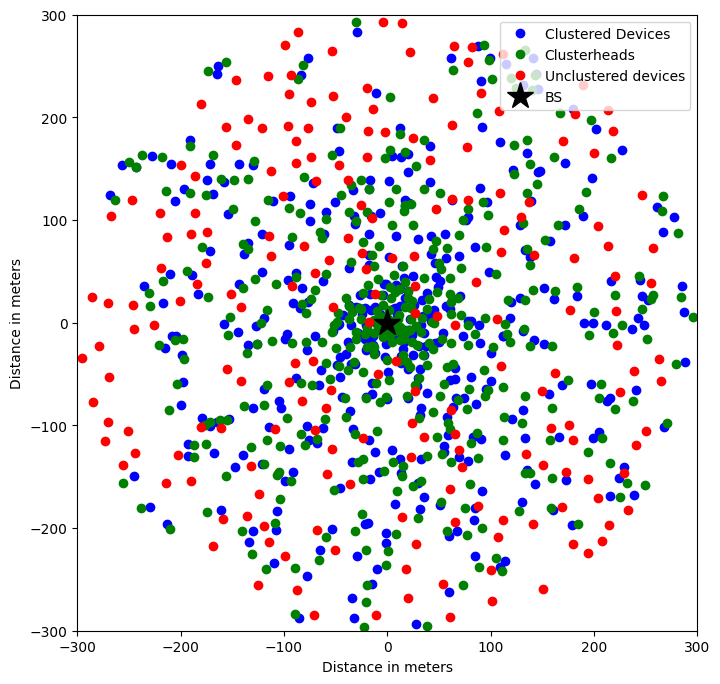

In [13]:
clusters_plotter(title=f'Number of devices: {number_of_mobile_devices_k}', figure_save_name=f'clusterization_part_1--{number_of_mobile_devices_k}_devices')

### Report

In [14]:
clusters_reporter()

There are 399 clusters in total.

From these clusters, there are:
399 clusters of size 2

Totalizing in 798 clustered devices (out of 1000), which means 79.80000000000001% of the devices were sucessfully clustered.
There is also 202 devices that did not group with any other device.


## Clusterization - part 2
Absorbing the unclustered devices from part 1 by the firstly created clusters.

In [15]:
# Checks all created clusters and sees if they can still grow up in size. If they can, 
# then they become part of the list of the available cluster(heads).
# The summation of +1 in the "if" clause is because the clusterhead itself is also part of the cluster.
temporary_list_of_available_clusterheads = [clusterhead for clusterhead in dict_of_clusters.keys() \
                                            if (len(dict_of_clusters[clusterhead]) + 1 < max_devices_per_cluster)]

temporary_list_of_unclustered_devices = list_of_unclustered_devices.copy()
for unclustered_device in temporary_list_of_unclustered_devices:
    unclustered_device_coords = devices_information_dict[unclustered_device]['x_y_coord']

    for clusterhead in temporary_list_of_available_clusterheads:
            clusterhead_coords = devices_information_dict[clusterhead]['x_y_coord']
            clusterheads_are_near = devices_proximity_checker(device_x_coords=unclustered_device_coords, 
                                                              device_y_coords=clusterhead_coords, 
                                                              devices_communication_radius=device_radius)
            if clusterheads_are_near is True:
                dict_of_clusters[clusterhead].append(unclustered_device)
                list_of_unclustered_devices.remove(unclustered_device)
                # Now, considering that the cluster has grown, it is necessary to recheck if it 
                # is still able to receive more devices or if it has grown to its maximum number.
                # In the below line. the summation of +1 is because the clusterhead itself is part of the cluster.
                cluster_size =  len(dict_of_clusters[clusterhead]) + 1 
                if cluster_size >= max_devices_per_cluster:
                    temporary_list_of_available_clusterheads.remove(clusterhead)
                else:
                    pass
                # As the unclustered device has now found a cluster to belong to, 
                # "break" the search for a cluster and go to the next unclustered device.
                break
            else:
                pass

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


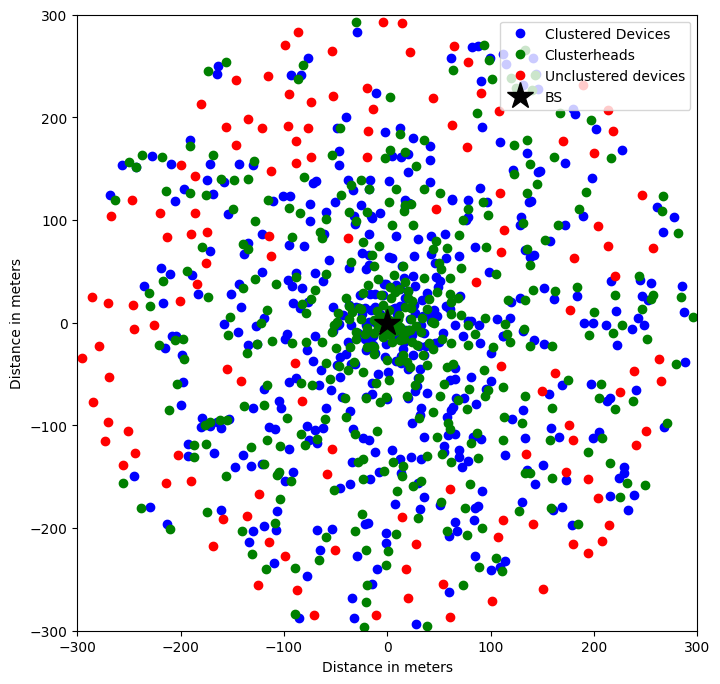

In [16]:
clusters_plotter(title=f'Number of devices: {number_of_mobile_devices_k}', figure_save_name=f'clusterization_part_2--{number_of_mobile_devices_k}_devices')

### Report

In [17]:
clusters_reporter()

There are 399 clusters in total.

From these clusters, there are:
330 clusters of size 2
66 clusters of size 3
3 clusters of size 4

Totalizing in 870 clustered devices (out of 1000), which means 87.0% of the devices were sucessfully clustered.
There is also 130 devices that did not group with any other device.


In [18]:
number_of_cluster_size_dict = dict()
for clusterhead in dict_of_clusters.keys():
    cluster_size = len(dict_of_clusters[clusterhead]) + 1
    if cluster_size in list(number_of_cluster_size_dict.keys()):
        number_of_cluster_size_dict[cluster_size] = number_of_cluster_size_dict[cluster_size] + 1
    else:
        number_of_cluster_size_dict[cluster_size] = 1

print(f'There are {len(dict_of_clusters)} clusters in total.')
print('')
print(f'From these clusters, there are:')
ordered_number_of_clusters = sorted(list(number_of_cluster_size_dict.keys()))
number_of_sucessfully_clustered_devices = 0
number_of_unsucessfully_clustered_devices = 0
for key in ordered_number_of_clusters:
    print(f'{number_of_cluster_size_dict[key]} clusters of size {key}')
    number_of_sucessfully_clustered_devices = number_of_sucessfully_clustered_devices + key*number_of_cluster_size_dict[key]

print('')    
print(f'Totalizing in {number_of_sucessfully_clustered_devices} clustered devices (out of {number_of_mobile_devices_k}), which means {number_of_sucessfully_clustered_devices/number_of_mobile_devices_k*100}% of the devices were sucessfully clustered.')
print(f'There was also {len(list_of_unclustered_devices)} devices that did not group with any other device (becoming auto clusterheads).')


There are 399 clusters in total.

From these clusters, there are:
330 clusters of size 2
66 clusters of size 3
3 clusters of size 4

Totalizing in 870 clustered devices (out of 1000), which means 87.0% of the devices were sucessfully clustered.
There was also 130 devices that did not group with any other device (becoming auto clusterheads).


## Clusterization - part 3
Changing the clusterhead from clusters of size 2 in order  to try to create a cluster of size 3.
- Grabs all the remaining clusters with size 2.
- Checks if the change of the clusterhead to the other device that was in the same cluster will now make it possible to encapsulate all 3 devices in the same cluster.
- If this change of the clusterhead can now encapsulate all 3 devices, proceed with the swap, else ignore (main the older clusterhead).

In [19]:
# Checks all created clusters and sees if they have the size 2.
# The summation of +1 in the "if" clause is because the clusterhead itself is also part of the cluster.
temporary_list_of_available_clusterheads = [clusterhead for clusterhead in dict_of_clusters.keys() \
                                            if (len(dict_of_clusters[clusterhead]) + 1 == 2)]

temporary_list_of_unclustered_devices = list_of_unclustered_devices.copy()
for unclustered_device in temporary_list_of_unclustered_devices:
    unclustered_device_coords = devices_information_dict[unclustered_device]['x_y_coord']

    for clusterhead in temporary_list_of_available_clusterheads:
        # This loops checks if the unclustered device and the member of the cluster analysed are near.
        # In the line below, there is only a single device inside the list, so the device 
        # will always be at the first position: "[0]".
        other_cluster_device = dict_of_clusters[clusterhead][0] 
        other_device_coords = devices_information_dict[other_cluster_device]['x_y_coord']
        devices_are_near = devices_proximity_checker(device_x_coords=unclustered_device_coords, 
                                                     device_y_coords=other_device_coords, 
                                                     devices_communication_radius=device_radius)
        if devices_are_near is True:
            old_clusterhead = clusterhead
            new_clusterhead = other_cluster_device
            dict_of_clusters[new_clusterhead] = [old_clusterhead, unclustered_device]

            dict_of_clusters.pop(old_clusterhead)
            list_of_unclustered_devices.remove(unclustered_device)
            temporary_list_of_available_clusterheads.remove(old_clusterhead)
            break
        else:
            pass

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


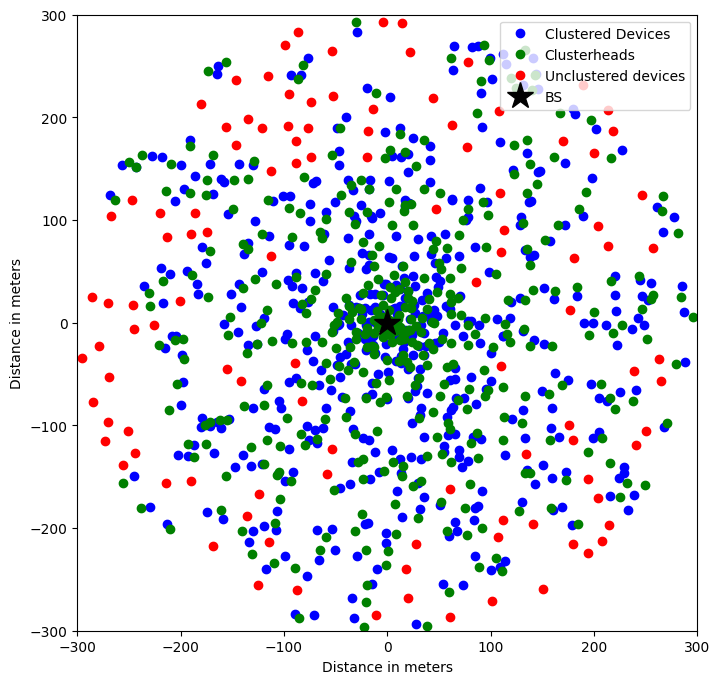

In [20]:
clusters_plotter(title=f'Number of devices: {number_of_mobile_devices_k}', figure_save_name=f'clusterization_part_3--{number_of_mobile_devices_k}_devices')

### Report

In [21]:
clusters_reporter()

There are 399 clusters in total.

From these clusters, there are:
309 clusters of size 2
87 clusters of size 3
3 clusters of size 4

Totalizing in 891 clustered devices (out of 1000), which means 89.1% of the devices were sucessfully clustered.
There is also 109 devices that did not group with any other device.


## Clusterization - part 4
Merging clusters into bigger ones.
- The clusterheads communicates with other clusterheads.
- If the clusterhead communicated is within the reach of the communicating clusterheads, then they may belong to the same cluster, so, all devices from the communicated clusterhead are also checked if they are within the reach of the communicating clusterhead.
- If the communicated clusterhead and ALL of its members are in the range of the communicating clusterhead, then the whole cluster is absorbed by the communicating clusterhead. 
- This process is repeated until either there is no more near clusters to be absorbed by the communicating clusterhead or the clusterhead that is absorbing other cluster has reached its maximum devices number.

In [22]:
temporary_list_of_available_clusterheads = list(dict_of_clusters.keys())
while len(temporary_list_of_available_clusterheads) != 0:
    reference_clusterhead = temporary_list_of_available_clusterheads[0]
    reference_clusterhead_coords = devices_information_dict[reference_clusterhead]['x_y_coord']
    temporary_list_of_available_clusterheads.remove(reference_clusterhead)

    for analysed_clusterhead in temporary_list_of_available_clusterheads:
        analysed_clusterhead_coords = devices_information_dict[analysed_clusterhead]['x_y_coord']
        clusterheads_are_near = devices_proximity_checker(device_x_coords=reference_clusterhead_coords, 
                                                          device_y_coords=analysed_clusterhead_coords, 
                                                          devices_communication_radius=device_radius)
        if clusterheads_are_near is True:
            # Clusterheads {reference_clusterhead} and {analysed_clusterhead} may belong to same cluster.
            # Checking if all points from the analysed cluster can be absorbed by the reference clustherhead.
            devices_that_need_checking = dict_of_clusters[analysed_clusterhead]
            number_of_ok_devices_needed = len(devices_that_need_checking)
            ok_devices_counter = 0
            for device in devices_that_need_checking:
                device_coords = devices_information_dict[device]['x_y_coord']
                devices_are_near = devices_proximity_checker(device_x_coords=reference_clusterhead_coords, 
                                                             device_y_coords=device_coords, 
                                                             devices_communication_radius=device_radius)
                if devices_are_near is True:
                    ok_devices_counter += 1
                else:
                    pass
            if number_of_ok_devices_needed == ok_devices_counter:
                # The clusters may be grouped. Executing merge.
                # Absorbs all devices that were part of the cluster from the old clusterhead 
                # (this loop does not includes the clusterhead itself).
                for device_to_be_absorbed in dict_of_clusters[analysed_clusterhead]:
                    dict_of_clusters[reference_clusterhead].append(device_to_be_absorbed)
                # Now the append of the old clusterhead is included.
                dict_of_clusters[reference_clusterhead].append(analysed_clusterhead)
                # And finally deletes the old cluster.
                dict_of_clusters.pop(analysed_clusterhead)
                temporary_list_of_available_clusterheads.remove(analysed_clusterhead)
            else:
                # The clusters could not be grouped because there was at least 1 point that could not be absorbed.
                pass

            # Now checks if the cluster can still grow or if it has reached its maximum devices number.
            # The summation of 1 is done in order to compensate the clusterhead, which is also part of the cluster,
            # and the subtraction of 1 is done so that there is no cluster that is 1 size higher than the maximum,
            # when a merge happen.
            if (len(dict_of_clusters[reference_clusterhead]) +1) >= max_devices_per_cluster - 1:
                break
            else:
                pass

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


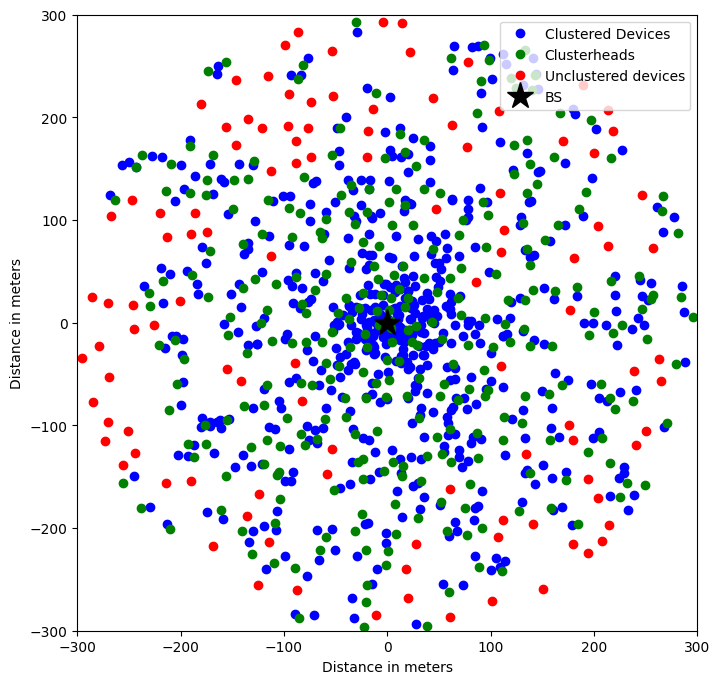

In [23]:
clusters_plotter(title=f'Number of devices: {number_of_mobile_devices_k}', figure_save_name=f'clusterization_part_4--{number_of_mobile_devices_k}_devices')

### Report

In [24]:
clusters_reporter()

There are 301 clusters in total.

From these clusters, there are:
176 clusters of size 2
69 clusters of size 3
22 clusters of size 4
11 clusters of size 5
5 clusters of size 6
4 clusters of size 7
3 clusters of size 8
3 clusters of size 9
8 clusters of size 10

Totalizing in 891 clustered devices (out of 1000), which means 89.1% of the devices were sucessfully clustered.
There is also 109 devices that did not group with any other device.


## Clusterization - part 5
Rebalancing. This step tries to balance the clusters based on the minimum cluster value.
- First, it classifies the clusters into clusters that can give devices away (and still have the minimum value of devices), and clusters that need more devices to achive the minimum devices number per cluster.
- Then, the clusters that need more devices analyzes if there is a nearby cluster that can give away devices (based on the 2*Device radius, the same way as in part 5) and "steals" the closest device from the larger cluster.

In [25]:
# This step classifies the cluster into "can give away" and "can receive".
list_of_clusterheads_that_can_give_away = list()
list_of_clusterheads_that_needs_more_devices = list()
for clusterhead in dict_of_clusters.keys():
    cluster_size = len(dict_of_clusters[clusterhead]) + 1
    if cluster_size > min_devices_per_cluster:
        list_of_clusterheads_that_can_give_away.append(clusterhead)
    elif cluster_size < min_devices_per_cluster:
        list_of_clusterheads_that_needs_more_devices.append(clusterhead)
    else:
        pass

aux_break = 0
for clusterhead_that_needs in list_of_clusterheads_that_needs_more_devices:
    current_status = None
    clusterhead_that_needs_coords = devices_information_dict[clusterhead_that_needs]['x_y_coord']

    # The below line removes the None values that were inserted during some 'for loops', which
    # compensates the removal of some values. I'm only removing these None values so that they are not
    # iterated again and again unnecessarily.
    list_of_clusterheads_that_can_give_away = [clusterhead_that_can_give for clusterhead_that_can_give in \
                                               list_of_clusterheads_that_can_give_away \
                                               if clusterhead_that_can_give is not None]
    for clusterhead_that_can_give in list_of_clusterheads_that_can_give_away:
        if aux_break == 1:
            # Resets the aux_break.
            aux_break = 0
        else:
            pass
        if clusterhead_that_can_give is not None and current_status is None:
            clusterhead_that_can_give_coords = devices_information_dict[clusterhead_that_can_give]['x_y_coord']
            clusterheads_are_near = devices_proximity_checker(device_x_coords=clusterhead_that_needs_coords, 
                                                              device_y_coords=clusterhead_that_can_give_coords, 
                                                              devices_communication_radius=device_radius*2)
            if clusterheads_are_near is True:
                for device in dict_of_clusters[clusterhead_that_can_give]:
                    device_coords = devices_information_dict[device]['x_y_coord']
                    devices_are_near = devices_proximity_checker(device_x_coords=clusterhead_that_needs_coords, 
                                                                 device_y_coords=device_coords, 
                                                                 devices_communication_radius=device_radius)
                    if devices_are_near is True: 
                        # The small cluster "steals" the device from the bigger cluster.
                        dict_of_clusters[clusterhead_that_needs].append(device)
                        dict_of_clusters[clusterhead_that_can_give].remove(device)
                        # Now it needs to check both: if the small cluster has reached its minimum value and if
                        # the bigger cluster can still give devices away.
                        clusterhead_that_needs_cluster_size = len(dict_of_clusters[clusterhead_that_needs]) + 1
                        clusterhead_that_can_give_cluster_size = len(dict_of_clusters[clusterhead_that_can_give]) + 1
                        if clusterhead_that_can_give_cluster_size <= min_devices_per_cluster:
                            list_of_clusterheads_that_can_give_away.remove(clusterhead_that_can_give)
                            # The below line is implemented in order to compensate the removal of one value 
                            # inside the list that is still looping under a for condition.
                            list_of_clusterheads_that_can_give_away.insert(0, None) 
                            aux_break = 1
                        else:
                            pass
                        if clusterhead_that_needs_cluster_size >= min_devices_per_cluster:
                            current_status = 'Smaller cluster does not need more devices'
                            aux_break = 1
                        else:
                            pass
                        if aux_break == 1:
                            # Stop 'stealing' from the same cluster either because the small 
                            # cluster reached its minimum, or because the bigger cluster cannot 
                            # give more devices away (it has also reached the minimum value).
                            break
                    else:
                        pass
            else:
                pass
        elif current_status == 'Smaller cluster does not need more devices':
            # Go to the next small cluster that still needs more devices.
            break
        else:
            pass

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


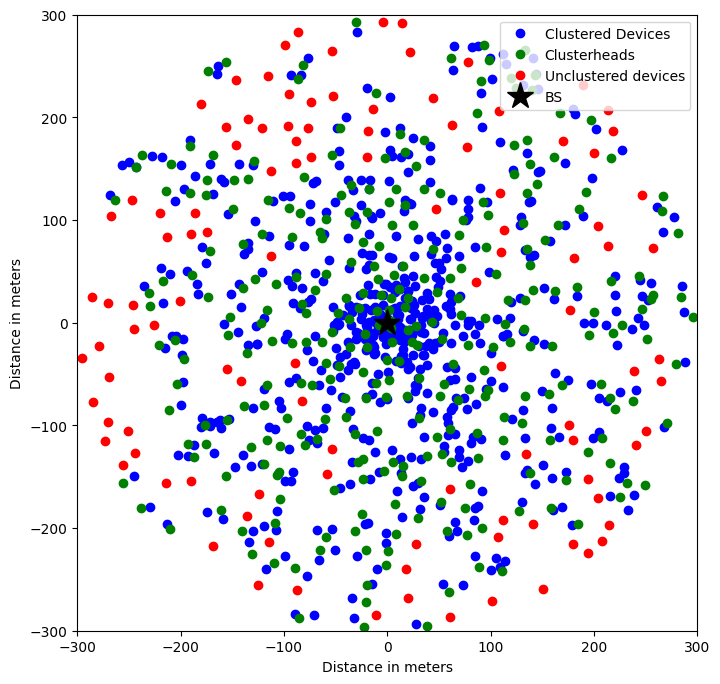

In [26]:
clusters_plotter(title=f'Number of devices: {number_of_mobile_devices_k}', figure_save_name=f'clusterization_part_5--{number_of_mobile_devices_k}_devices')

### Report

In [27]:
clusters_reporter()

There are 301 clusters in total.

From these clusters, there are:
158 clusters of size 2
75 clusters of size 3
42 clusters of size 4
7 clusters of size 5
5 clusters of size 6
3 clusters of size 7
6 clusters of size 8
2 clusters of size 9
3 clusters of size 10

Totalizing in 891 clustered devices (out of 1000), which means 89.1% of the devices were sucessfully clustered.
There is also 109 devices that did not group with any other device.


## Clusterization - part 6
Final step: unclustered devices becomes a single cluster.
- The unclustered devices becomes a single cluster, where the device itself is the clusterhead.
- The last step is shuffling the clusters (so that we do not get a sequence of clusters of size 1, for instance)

In [28]:
final_clusters_generated = list()
for unclustered_device in list_of_unclustered_devices:
    final_clusters_generated.append([unclustered_device])

for key, value in dict_of_clusters.items():
    temp_cluster_composition = list()
    clusterhead = key
    temp_cluster_composition.append(key)
    list_of_cluster_members = value
    for cluster_member in list_of_cluster_members:
        temp_cluster_composition.append(cluster_member)
    final_clusters_generated.append(temp_cluster_composition)

In [29]:
clusters = final_clusters_generated
shuffle(clusters)

### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


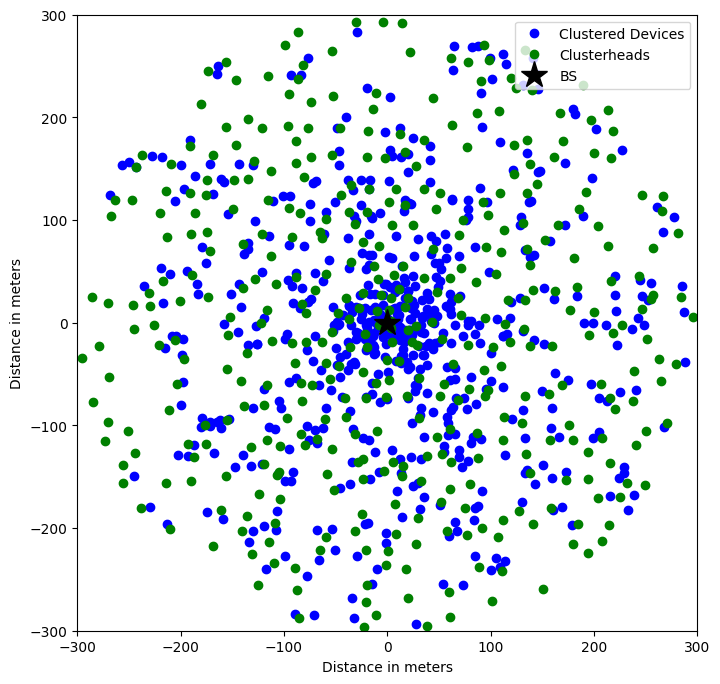

In [30]:
list_of_devices_x_coord = list()
list_of_devices_y_coord = list()

list_of_clusterheads_x_coords = list()
list_of_clusterheads_y_coords = list()

list_of_unclustered_devices_x_coords = list()
list_of_unclustered_devices_y_coords = list()

for clusterhead in dict_of_clusters.keys():
    # Clusterheads.
    clusterhead_x_coord = devices_information_dict[clusterhead]['x_y_coord'][0]
    list_of_clusterheads_x_coords.append(clusterhead_x_coord)
    clusterhead_y_coord = devices_information_dict[clusterhead]['x_y_coord'][1]
    list_of_clusterheads_y_coords.append(clusterhead_y_coord)

    # Clustered devices.
    for device in dict_of_clusters[clusterhead]:
        device_x_coord = devices_information_dict[device]['x_y_coord'][0]
        list_of_devices_x_coord.append(device_x_coord)
        device_y_coord = devices_information_dict[device]['x_y_coord'][1]
        list_of_devices_y_coord.append(device_y_coord)

# Unclustered devices.
for device in list_of_unclustered_devices:
    device_x_coord = devices_information_dict[device]['x_y_coord'][0]
    list_of_unclustered_devices_x_coords.append(device_x_coord)
    device_y_coord = devices_information_dict[device]['x_y_coord'][1]
    list_of_unclustered_devices_y_coords.append(device_y_coord)

plt.Figure()
plt.rcParams["figure.figsize"] = [8, 8]
plt.plot(list_of_devices_x_coord, list_of_devices_y_coord, 'bo', label='Clustered Devices')
plt.plot(list_of_clusterheads_x_coords+list_of_unclustered_devices_x_coords, 
         list_of_clusterheads_y_coords+list_of_unclustered_devices_y_coords, 'go', label='Clusterheads')
plt.plot(0, 0, 'k*', markersize=20, label='BS')
plt.xlim([0-BS_RADIUS, 0+BS_RADIUS])
plt.ylim([0-BS_RADIUS, 0+BS_RADIUS])
plt.legend(loc="upper right")
# plt.title(title)
plt.xlabel('Distance in meters')
plt.ylabel('Distance in meters')

plt.savefig(f'Figures/clusterization_part_6--{number_of_mobile_devices_k}_devices.eps', format='eps')
plt.show()

# Final checkings

## Distance

In [31]:
number_of_problems_found = 0
for clusterhead in dict_of_clusters.keys():
    clusterhead_coords = devices_information_dict[clusterhead]['x_y_coord']
    
    for cluster_member in dict_of_clusters[clusterhead]:
        cluster_member_coords = devices_information_dict[cluster_member]['x_y_coord']
        distance = dist(clusterhead_coords, cluster_member_coords)
        if distance <= device_radius:
            pass
        else:
            number_of_problems_found += 1
            print(f'Problem found within clusterhead {clusterhead} and device {cluster_member}. Their distances are {distance}')
            
if number_of_problems_found == 0:
    print('All clusters are ok. No distance problems found.')

All clusters are ok. No distance problems found.


## Participating clusters

In [32]:
list_of_devices_that_were_not_found = list()
for device in devices_information_dict.keys():
    is_value_present = is_value_present_checker(dict_of_clusters, device) 
    if is_value_present != -1:
        if len(is_value_present) == 1:
            # Ok condition
            pass
        elif len(is_value_present) > 1:
            print('A problem was found. The device is participating in more than 1 cluster at the same time.')
            break
        else:
            pass
    else:
        if device in dict_of_clusters.keys():
            pass
        else:
            list_of_devices_that_were_not_found.append(device)

        
if sorted(list_of_unclustered_devices) == sorted(list_of_devices_that_were_not_found):
    print('Test passed. There is no device participating in more than 1 cluster at a time.')
else:
    print('Test reproved!')

Test passed. There is no device participating in more than 1 cluster at a time.


# DBSCAN Comparison

In [33]:
x_y_coords = list()

for x_coord, y_coord in zip(x_coords_list, y_coords_list):
    x_y_coords.append([x_coord, y_coord])
x_y_coords = np.array(x_y_coords)

In [34]:
dbscan = DBSCAN(eps=device_radius, min_samples=2)
cluster_predicted = dbscan.fit_predict(x_y_coords)

## Plot

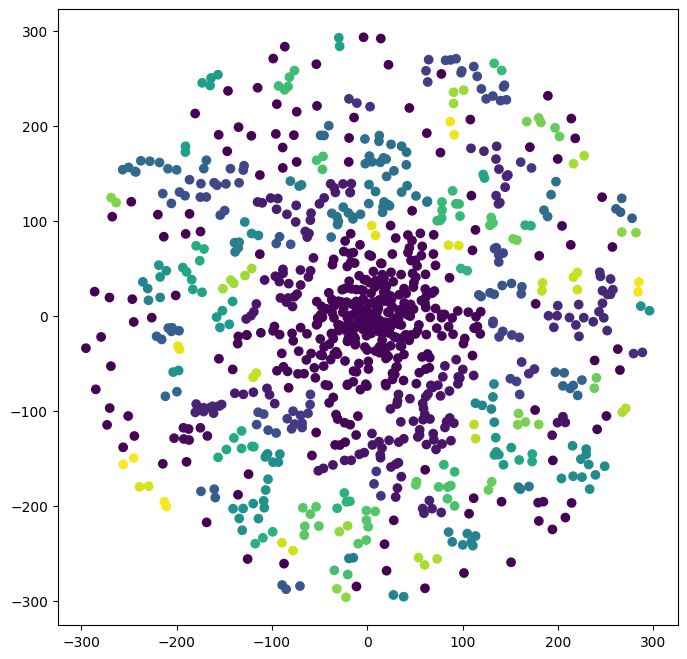

In [35]:
plt.scatter(x_y_coords[:, 0], x_y_coords[:, 1], c= cluster_predicted)
plt.savefig(f'Figures/DBSCAN_{number_of_mobile_devices_k}_devices.eps', format='eps')

## Report

In [36]:
number_of_clusters = len(set(cluster_predicted))-1 # -1 is because of the "-1" cluster, which is considered the noise "cluster".
print(f"Number of clusters: {number_of_clusters}")

## This same information could be obtained with the following:
# n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
# print(f"No of clusters: {n_clusters_}")

Number of clusters: 112


In [37]:
# # Sizes of each cluster
# for cluster_id in np.unique(dbscan.labels_):
#     if cluster_id != -1: # Exclude noise points
#         print(f'Cluster {cluster_id} size: {list(dbscan.labels_).count(cluster_id)}')

In [38]:
# Count the occurrences of each label (excluding noise)
cluster_sizes = Counter(dbscan.labels_[dbscan.labels_ != -1])

# Count how many clusters there are of each size
size_distribution = Counter(cluster_sizes.values())

# Print the distribution
for size, count in sorted(size_distribution.items()):
    print(f'Clusters of size {size}: {count}')

number_of_clustered_devices = Counter(dbscan.labels_[dbscan.labels_ == -1])
print('')
print(f'Number of unclustered devices: {number_of_clustered_devices.values()}')

Clusters of size 2: 43
Clusters of size 3: 22
Clusters of size 4: 9
Clusters of size 5: 9
Clusters of size 6: 8
Clusters of size 7: 4
Clusters of size 8: 1
Clusters of size 9: 2
Clusters of size 10: 3
Clusters of size 11: 3
Clusters of size 14: 1
Clusters of size 15: 1
Clusters of size 17: 1
Clusters of size 19: 1
Clusters of size 21: 1
Clusters of size 22: 1
Clusters of size 62: 1
Clusters of size 328: 1

Number of unclustered devices: dict_values([104])
